In [12]:
# importar paquetes a ocupar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gradio
import os

In [13]:
# importar archivos
crossBattlelog = pd.read_parquet('datasets/teams/battlelog_teams.parquet')
crossBattlelog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605765 entries, 0 to 605764
Data columns (total 44 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   battleTime                             605765 non-null  object 
 1   playertag                              605765 non-null  object 
 2   event_mode                             605765 non-null  object 
 3   event_map                              605765 non-null  object 
 4   battle_type                            605765 non-null  object 
 5   battle_result                          605765 non-null  object 
 6   battle_duration                        605765 non-null  float64
 7   battle_trophyChange                    450501 non-null  float64
 8   battle_team1_player1_tag               605765 non-null  object 
 9   battle_team1_player1_name              605761 non-null  object 
 10  battle_team1_player1_brawler_id        605765 non-null  

In [14]:
# leer brawler stats
brawlers = pd.read_parquet('datasets/brawlers/brawlers_stats.parquet')
brawlers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              64 non-null     int64  
 1   name            64 non-null     object 
 2   starPowers.0    64 non-null     object 
 3   starPowers.1    64 non-null     object 
 4   gadgets.0       64 non-null     object 
 5   gadgets.1       64 non-null     object 
 6   Brawler         64 non-null     object 
 7   Health          64 non-null     float64
 8   Rarity          64 non-null     object 
 9   Class           64 non-null     object 
 10  Movement_Speed  64 non-null     object 
 11  Range           63 non-null     object 
 12  Reload          63 non-null     object 
 13  Speed_Num       64 non-null     int64  
 14  Range_Num       64 non-null     float64
 15  Reload_Num      63 non-null     float64
 16  Role            64 non-null     object 
dtypes: float64(3), int64(2), object(12)
m

In [15]:
# leer datos de mapa
bushList = pd.read_csv('datasets/maps/bushList.csv', index_col=0)
bushList.columns = bushList.columns.str.replace('.', '_')
waterList = pd.read_csv('datasets/maps/waterList.csv', index_col=0)
waterList.columns = waterList.columns.str.replace('.', '_')
barrierList = pd.read_csv('datasets/maps/barrierList.csv', index_col=0)
barrierList.columns = barrierList.columns.str.replace('.', '_')

C:\Users\alniquia\AppData\Local\Temp\ipykernel_10804\3581368576.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  bushList.columns = bushList.columns.str.replace('.', '_')
C:\Users\alniquia\AppData\Local\Temp\ipykernel_10804\3581368576.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  waterList.columns = waterList.columns.str.replace('.', '_')
C:\Users\alniquia\AppData\Local\Temp\ipykernel_10804\3581368576.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  barrierList.columns = barrierList.columns.str.replace('.', '

In [16]:
# leer brawler winrate y userate
brawler_wr_ur = pd.read_parquet('datasets/teams/brawler_winrate_userate.parquet')
brawler_wr_ur_overall = pd.read_parquet('datasets/teams/brawler_winrate_userate_overall.parquet')

In [17]:
# función para identificar a que team pertenece el player
def team_assignment(row):
    if any(row['playertag'] == tag for tag in [row.battle_team1_player1_tag, row.battle_team1_player2_tag, row.battle_team1_player3_tag]):
        return 'team1'
    elif any(row['playertag'] == tag for tag in [row.battle_team2_player1_tag, row.battle_team2_player2_tag, row.battle_team2_player3_tag]):
        return 'team2'
    else:
        return "error in team assignation for id " + str(row.name)

crossBattlelog['player_team'] = crossBattlelog.apply(team_assignment, axis=1)

crossBattlelog['player_team'].value_counts()

team1    304655
team2    301110
Name: player_team, dtype: int64

In [18]:
# eliminar draws, no aportan al modelo
crossBattlelog = crossBattlelog[crossBattlelog['battle_result'] != 'draw'].reset_index(drop=True)

In [20]:
# crear columna winner_team
def winner_assignment(row):
	if row.battle_result == 'draw':
		return 'draw'
	elif (row.player_team == 'team1' and row.battle_result == 'victory') or (row.player_team == 'team2' and row.battle_result == 'defeat'):
		return 'team1'
	elif (row.player_team == 'team2' and row.battle_result == 'victory') or (row.player_team == 'team1' and row.battle_result == 'defeat'):
		return 'team2'
	else:
		return "error in winner assignation for id " + str(row.name)

crossBattlelog['winner_team'] = crossBattlelog.apply(winner_assignment, axis=1)

crossBattlelog['winner_team'].value_counts()

team1    304359
team2    297551
Name: winner_team, dtype: int64

In [21]:
#escoger columnas a ocupar
crossBattlelog = crossBattlelog[[	
	'event_mode'
	,'event_map'
	,'battle_type'
	,'battle_duration'
	,'battle_team1_player1_brawler_name'
	,'battle_team1_player1_brawler_power'
	,'battle_team1_player1_brawler_trophies'
	,'battle_team1_player2_brawler_name'
	,'battle_team1_player2_brawler_power'
	,'battle_team1_player2_brawler_trophies'
	,'battle_team1_player3_brawler_name'
	,'battle_team1_player3_brawler_power'
	,'battle_team1_player3_brawler_trophies'
	,'battle_team2_player1_brawler_name'
	,'battle_team2_player1_brawler_power'
	,'battle_team2_player1_brawler_trophies'
	,'battle_team2_player2_brawler_name'
	,'battle_team2_player2_brawler_power'
	,'battle_team2_player2_brawler_trophies'
	,'battle_team2_player3_brawler_name'
	,'battle_team2_player3_brawler_power'
	,'battle_team2_player3_brawler_trophies'
	,'player_team'
	,'winner_team'
]]

crossBattlelog.head()

,event_mode,event_map,battle_type,battle_duration,battle_team1_player1_brawler_name,battle_team1_player1_brawler_power,battle_team1_player1_brawler_trophies,battle_team1_player2_brawler_name,battle_team1_player2_brawler_power,battle_team1_player2_brawler_trophies,...,battle_team2_player1_brawler_power,battle_team2_player1_brawler_trophies,battle_team2_player2_brawler_name,battle_team2_player2_brawler_power,battle_team2_player2_brawler_trophies,battle_team2_player3_brawler_name,battle_team2_player3_brawler_power,battle_team2_player3_brawler_trophies,player_team,winner_team
0,knockout,Goldarm Gulch,ranked,94.0,BELLE,9.0,698.0,BO,11.0,714.0,...,10.0,704.0,CARL,10.0,659.0,BONNIE,11.0,698.0,team1,team2
1,knockout,Goldarm Gulch,ranked,133.0,TICK,11.0,658.0,BIBI,9.0,675.0,...,9.0,656.0,GRAY,11.0,689.0,BO,11.0,706.0,team2,team2
2,knockout,Goldarm Gulch,ranked,72.0,MORTIS,11.0,672.0,RICO,10.0,655.0,...,11.0,681.0,CROW,9.0,648.0,BO,11.0,698.0,team2,team2
3,knockout,Goldarm Gulch,ranked,61.0,CROW,11.0,655.0,GROM,9.0,598.0,...,8.0,312.0,LEON,10.0,702.0,BEA,11.0,678.0,team1,team1
4,knockout,Goldarm Gulch,ranked,137.0,CROW,11.0,647.0,GROM,9.0,590.0,...,11.0,655.0,JANET,9.0,676.0,MORTIS,11.0,670.0,team1,team1


In [22]:
# crear columna winner
def subset_winner(df, team):

	df['winner'] = 'no'

	for i, winner_team in enumerate(df['winner_team']):
		if winner_team == team:
			df.loc[i, 'winner'] = 'yes'

	df = df.rename(columns={
		'battle_' + team + '_player1_brawler_name': 'battle_player1_brawler_name'
		,'battle_' + team + '_player1_brawler_power': 'battle_player1_brawler_power'
		,'battle_' + team + '_player1_brawler_trophies': 'battle_player1_brawler_trophies'
		,'battle_' + team + '_player2_brawler_name': 'battle_player2_brawler_name'
		,'battle_' + team + '_player2_brawler_power': 'battle_player2_brawler_power'
		,'battle_' + team + '_player2_brawler_trophies': 'battle_player2_brawler_trophies'
		,'battle_' + team + '_player3_brawler_name': 'battle_player3_brawler_name'
		,'battle_' + team + '_player3_brawler_power': 'battle_player3_brawler_power'
		,'battle_' + team + '_player3_brawler_trophies': 'battle_player3_brawler_trophies'
	})

	df = df[[	
		'event_mode'
		,'event_map'
		,'battle_type'
		,'battle_duration'
		,'battle_player1_brawler_name'
		,'battle_player1_brawler_power'
		,'battle_player1_brawler_trophies'
		,'battle_player2_brawler_name'
		,'battle_player2_brawler_power'
		,'battle_player2_brawler_trophies'
		,'battle_player3_brawler_name'
		,'battle_player3_brawler_power'
		,'battle_player3_brawler_trophies'
		,'winner'
	]]

	return df

def clean_winner(team):

	if team == 'team1':
		oteam = 'team2'
	else:
		oteam = 'team1'
	
	subset = crossBattlelog[crossBattlelog['winner_team'] == team].reset_index(drop=True)

	dfwinners = subset_winner(subset, team)

	dfloosers = subset_winner(subset, oteam)

	return pd.concat([dfwinners, dfloosers], ignore_index=True)

team1 = clean_winner('team1')
team2 = clean_winner('team2')

battlelogProcess = pd.concat([team1, team2], ignore_index=True)
battlelogProcess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1203820 entries, 0 to 1203819
Data columns (total 14 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   event_mode                       1203820 non-null  object 
 1   event_map                        1203820 non-null  object 
 2   battle_type                      1203820 non-null  object 
 3   battle_duration                  1203820 non-null  float64
 4   battle_player1_brawler_name      1203820 non-null  object 
 5   battle_player1_brawler_power     1203820 non-null  float64
 6   battle_player1_brawler_trophies  1203820 non-null  float64
 7   battle_player2_brawler_name      1203820 non-null  object 
 8   battle_player2_brawler_power     1203820 non-null  float64
 9   battle_player2_brawler_trophies  1203820 non-null  float64
 10  battle_player3_brawler_name      1203819 non-null  object 
 11  battle_player3_brawler_power     1203819 non-null 

In [23]:
battlelogProcess.head()

,event_mode,event_map,battle_type,battle_duration,battle_player1_brawler_name,battle_player1_brawler_power,battle_player1_brawler_trophies,battle_player2_brawler_name,battle_player2_brawler_power,battle_player2_brawler_trophies,battle_player3_brawler_name,battle_player3_brawler_power,battle_player3_brawler_trophies,winner
0,knockout,Goldarm Gulch,ranked,61.0,CROW,11.0,655.0,GROM,9.0,598.0,BO,11.0,690.0,yes
1,knockout,Goldarm Gulch,ranked,137.0,CROW,11.0,647.0,GROM,9.0,590.0,BO,11.0,682.0,yes
2,knockout,Goldarm Gulch,ranked,118.0,CROW,11.0,639.0,GROM,9.0,582.0,BO,11.0,674.0,yes
3,gemGrab,Gem Fort,ranked,86.0,GRIFF,11.0,700.0,BROCK,11.0,648.0,CROW,10.0,682.0,yes
4,gemGrab,Gem Fort,ranked,162.0,SURGE,9.0,616.0,NITA,10.0,669.0,TICK,11.0,703.0,yes


In [24]:
# merge brawler stats
battlelogFinal = battlelogProcess

def add_brawlers(df, prefix):
	df = pd.merge(left=df, right=brawlers[['name','Health','Rarity','Class','Movement_Speed','Range','Reload','Speed_Num','Range_Num','Reload_Num','Role']].add_prefix(prefix), on=prefix + 'name', how='left', suffixes=('','_b'))
	return df

battlelogFinal = add_brawlers(battlelogFinal, 'battle_player1_brawler_')
battlelogFinal = add_brawlers(battlelogFinal, 'battle_player2_brawler_')
battlelogFinal = add_brawlers(battlelogFinal, 'battle_player3_brawler_')

battlelogFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1203820 entries, 0 to 1203819
Data columns (total 44 columns):
 #   Column                                 Non-Null Count    Dtype  
---  ------                                 --------------    -----  
 0   event_mode                             1203820 non-null  object 
 1   event_map                              1203820 non-null  object 
 2   battle_type                            1203820 non-null  object 
 3   battle_duration                        1203820 non-null  float64
 4   battle_player1_brawler_name            1203820 non-null  object 
 5   battle_player1_brawler_power           1203820 non-null  float64
 6   battle_player1_brawler_trophies        1203820 non-null  float64
 7   battle_player2_brawler_name            1203820 non-null  object 
 8   battle_player2_brawler_power           1203820 non-null  float64
 9   battle_player2_brawler_trophies        1203820 non-null  float64
 10  battle_player3_brawler_name            120

In [25]:
# merge map data
battlelogFinal = battlelogFinal.merge(barrierList, how='inner', on='event_map')
battlelogFinal = battlelogFinal.merge(bushList, how='inner', on='event_map')
battlelogFinal = battlelogFinal.merge(waterList, how='left', on='event_map')
battlelogFinal['waterProp'] = battlelogFinal['waterProp'].fillna(0)
battlelogFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1203820 entries, 0 to 1203819
Data columns (total 49 columns):
 #   Column                                 Non-Null Count    Dtype  
---  ------                                 --------------    -----  
 0   event_mode                             1203820 non-null  object 
 1   event_map                              1203820 non-null  object 
 2   battle_type                            1203820 non-null  object 
 3   battle_duration                        1203820 non-null  float64
 4   battle_player1_brawler_name            1203820 non-null  object 
 5   battle_player1_brawler_power           1203820 non-null  float64
 6   battle_player1_brawler_trophies        1203820 non-null  float64
 7   battle_player2_brawler_name            1203820 non-null  object 
 8   battle_player2_brawler_power           1203820 non-null  float64
 9   battle_player2_brawler_trophies        1203820 non-null  float64
 10  battle_player3_brawler_name            120

In [26]:
# merge winrate y userate
def add_wr_ur(df, prefix):
	df = pd.merge(
		left=df
		,right=brawler_wr_ur[['brawlername', 'event_mode', 'event_map', 'winrate', 'userate', 'percentile_quadrant']].add_prefix(prefix)
		,left_on=[prefix + 'name', 'event_mode', 'event_map']
		,right_on=[prefix + 'brawlername', prefix + 'event_mode', prefix + 'event_map']
		,how='left'
		,suffixes=('','_w'))
	return df

battlelogFinal = add_wr_ur(battlelogFinal, 'battle_player1_brawler_')
battlelogFinal = add_wr_ur(battlelogFinal, 'battle_player2_brawler_')
battlelogFinal = add_wr_ur(battlelogFinal, 'battle_player3_brawler_')

battlelogFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1203820 entries, 0 to 1203819
Data columns (total 67 columns):
 #   Column                                      Non-Null Count    Dtype  
---  ------                                      --------------    -----  
 0   event_mode                                  1203820 non-null  object 
 1   event_map                                   1203820 non-null  object 
 2   battle_type                                 1203820 non-null  object 
 3   battle_duration                             1203820 non-null  float64
 4   battle_player1_brawler_name                 1203820 non-null  object 
 5   battle_player1_brawler_power                1203820 non-null  float64
 6   battle_player1_brawler_trophies             1203820 non-null  float64
 7   battle_player2_brawler_name                 1203820 non-null  object 
 8   battle_player2_brawler_power                1203820 non-null  float64
 9   battle_player2_brawler_trophies             1203820 non-n

In [27]:
# merge winrate y userate overall
def add_wr_ur_oa(df, prefix):
	df = pd.merge(
		left=df
		,right=brawler_wr_ur_overall[['brawlername', 'winrate', 'userate', 'percentile_quadrant']].add_prefix(prefix)
		,left_on=[prefix + 'name']
		,right_on=[prefix + 'brawlername']
		,how='left'
		,suffixes=('','_overall'))
	return df

battlelogFinal = add_wr_ur_oa(battlelogFinal, 'battle_player1_brawler_')
battlelogFinal = add_wr_ur_oa(battlelogFinal, 'battle_player2_brawler_')
battlelogFinal = add_wr_ur_oa(battlelogFinal, 'battle_player3_brawler_')

battlelogFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1203820 entries, 0 to 1203819
Data columns (total 79 columns):
 #   Column                                              Non-Null Count    Dtype  
---  ------                                              --------------    -----  
 0   event_mode                                          1203820 non-null  object 
 1   event_map                                           1203820 non-null  object 
 2   battle_type                                         1203820 non-null  object 
 3   battle_duration                                     1203820 non-null  float64
 4   battle_player1_brawler_name                         1203820 non-null  object 
 5   battle_player1_brawler_power                        1203820 non-null  float64
 6   battle_player1_brawler_trophies                     1203820 non-null  float64
 7   battle_player2_brawler_name                         1203820 non-null  object 
 8   battle_player2_brawler_power                        

In [29]:
plt.style.use('ggplot')

C:\Users\alniquia\AppData\Local\Temp\ipykernel_10804\1585452154.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  battlelogFinal['battle_avgpower'] = battlelogFinal.apply(lambda row: create_avg(row, 'power'), axis=1)


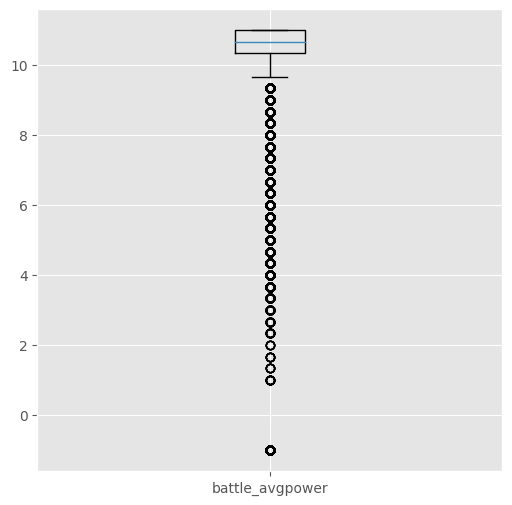

In [30]:
# crear columna avg power
def create_avg(row, column):
    return (row['battle_player1_brawler_'+ column] + row['battle_player2_brawler_'+ column] + row['battle_player3_brawler_'+ column]) / 3

def create_boxplots(df, col1):
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 6)
    ax.boxplot(df[col1])
    ax.set_xticklabels([col1])
    plt.show()

battlelogFinal['battle_avgpower'] = battlelogFinal.apply(lambda row: create_avg(row, 'power'), axis=1)
battlelogFinal = battlelogFinal[battlelogFinal['battle_avgpower'].isna() == False]
battlelogFinal['battle_avgpower'] = battlelogFinal.apply(lambda row: create_avg(row, 'power'), axis=1)
battlelogFinal = battlelogFinal[battlelogFinal['battle_avgpower'].isna() == False]

create_boxplots(battlelogFinal, 'battle_avgpower')

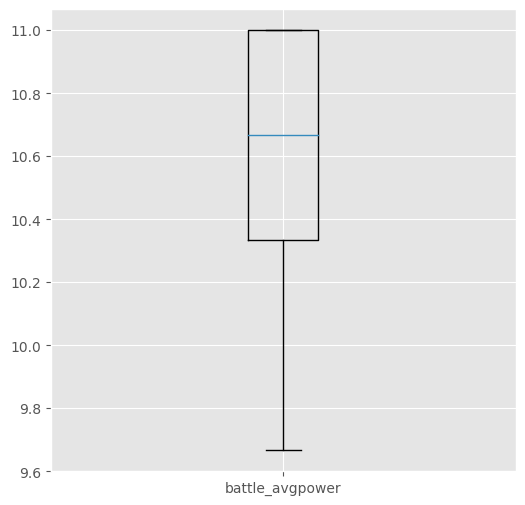

In [31]:
# subset avg power
battlelogFinal = battlelogFinal[battlelogFinal['battle_avgpower'] > 9.5].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avgpower')

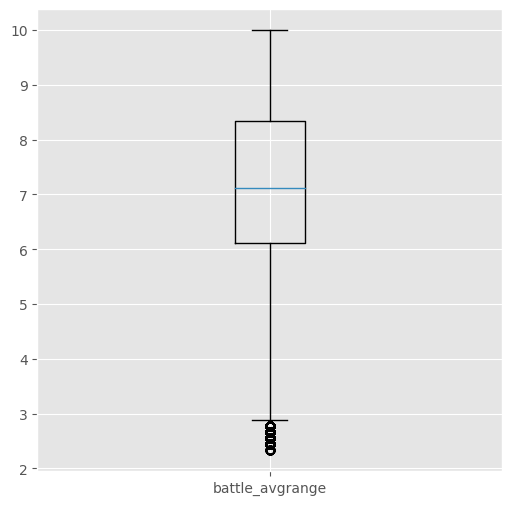

In [32]:
# crear columna avg range
battlelogFinal['battle_avgrange'] = battlelogFinal.apply(lambda row: create_avg(row, 'Range_Num'), axis=1)

create_boxplots(battlelogFinal, 'battle_avgrange')

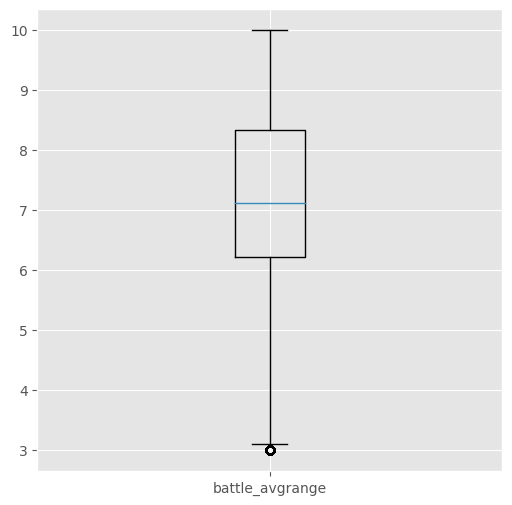

In [33]:
# subset avg range
battlelogFinal = battlelogFinal[battlelogFinal['battle_avgrange'] > 2.9].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avgrange')

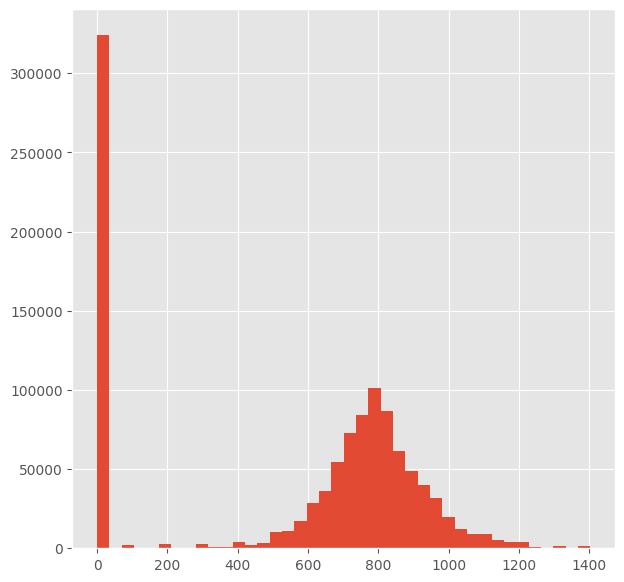

In [34]:
# crear columna avg trophies
battlelogFinal['battle_avgtrophies'] = battlelogFinal.apply(lambda row: create_avg(row, 'trophies'), axis=1)

fig, ax = plt.subplots(figsize=(7,7))
ax.hist(x=battlelogFinal['battle_avgtrophies'], bins=40)
plt.show()

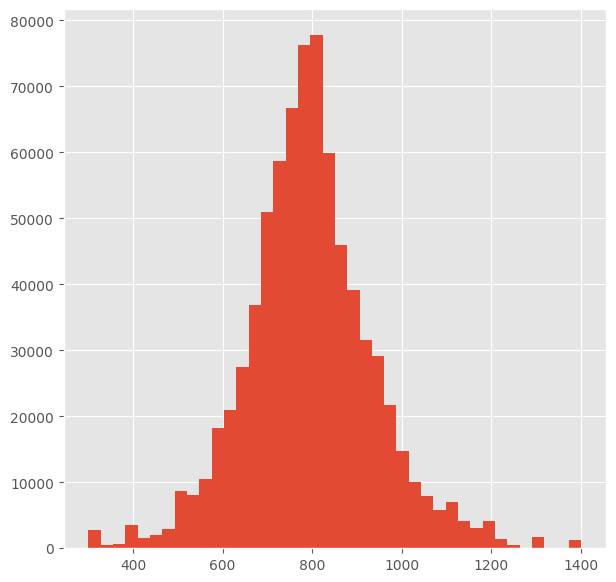

In [35]:
# subset avg trophies
battlelogFinal = battlelogFinal[battlelogFinal['battle_avgtrophies'] >= 300].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(7,7))
ax.hist(x=battlelogFinal['battle_avgtrophies'], bins=40)
plt.show()

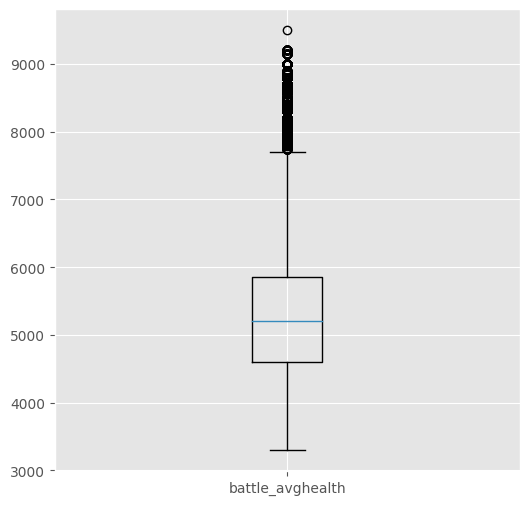

In [36]:
# crear columna avg health
battlelogFinal['battle_avghealth'] = battlelogFinal.apply(lambda row: create_avg(row, 'Health'), axis=1).reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avghealth')

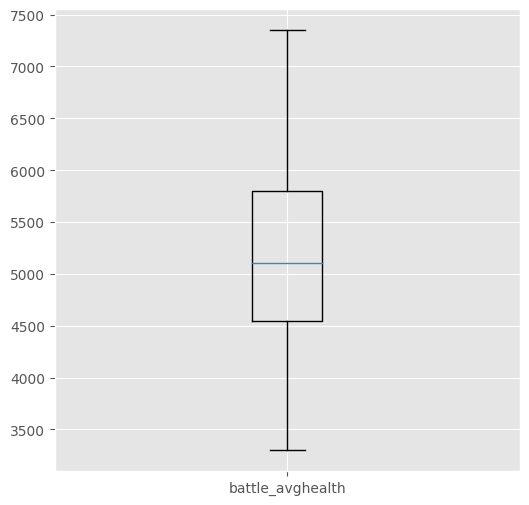

In [37]:
# subset avg health
battlelogFinal = battlelogFinal[battlelogFinal['battle_avghealth'] < 7400].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avghealth')

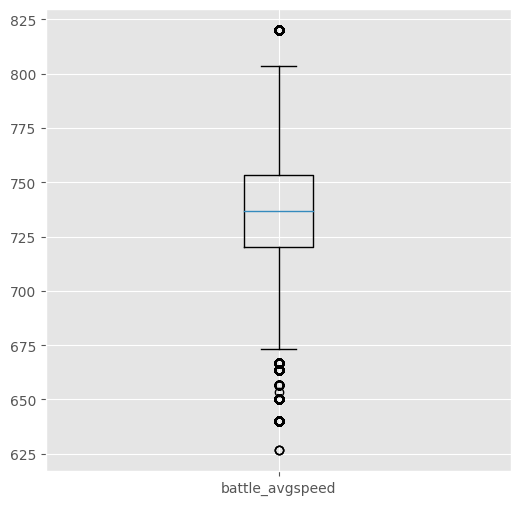

In [38]:
# crear columna avg speed
battlelogFinal['battle_avgspeed'] = battlelogFinal.apply(lambda row: create_avg(row, 'Speed_Num'), axis=1)

create_boxplots(battlelogFinal, 'battle_avgspeed')

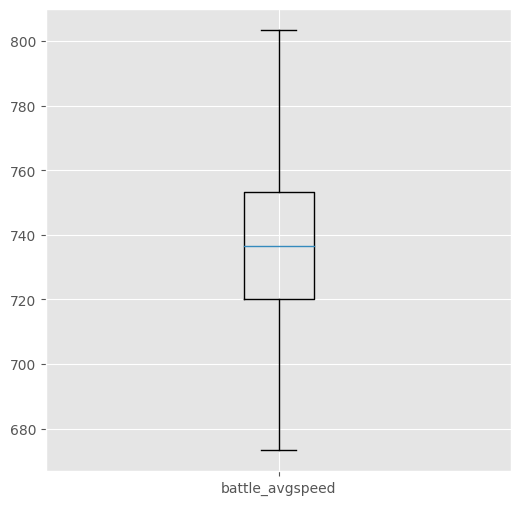

In [39]:
# subset avg speed
battlelogFinal = battlelogFinal[(battlelogFinal['battle_avgspeed'] >= 670) & (battlelogFinal['battle_avgspeed'] <= 810)].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avgspeed')

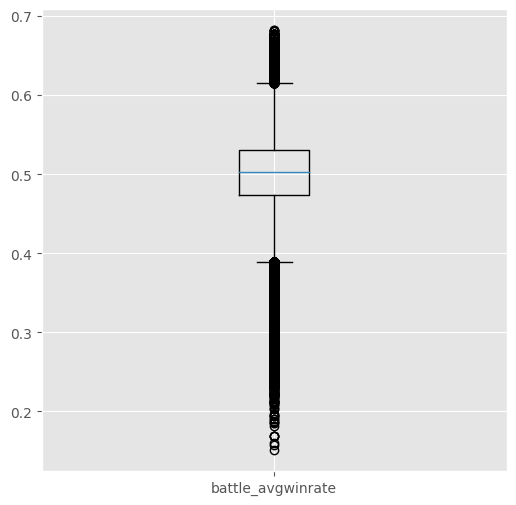

In [40]:
# crear columna avg winrate
battlelogFinal['battle_avgwinrate'] = battlelogFinal.apply(lambda row: create_avg(row, 'winrate'), axis=1)
battlelogFinal = battlelogFinal[battlelogFinal['battle_avgwinrate'].isna() == False]

create_boxplots(battlelogFinal, 'battle_avgwinrate')

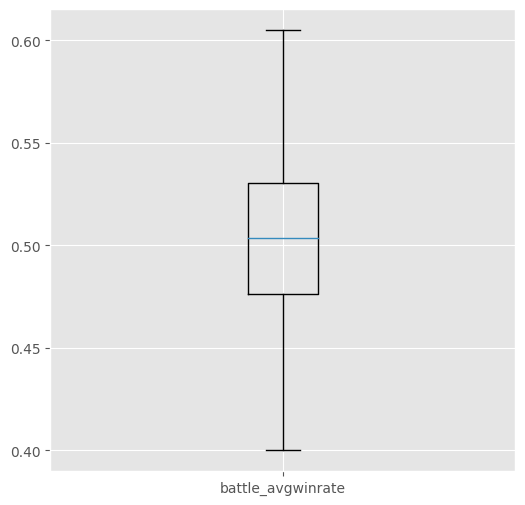

In [43]:
# subset avg winrate
battlelogFinal = battlelogFinal[(battlelogFinal['battle_avgwinrate'] >= 0.4) & (battlelogFinal['battle_avgwinrate'] <= 0.605)].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avgwinrate')

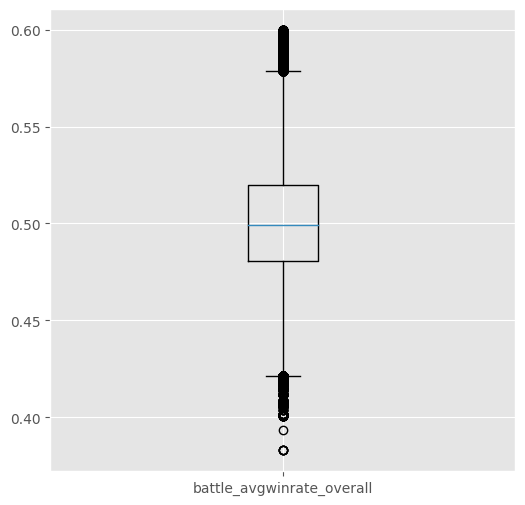

In [42]:
# crear columna avg winrate
battlelogFinal['battle_avgwinrate_overall'] = battlelogFinal.apply(lambda row: create_avg(row, 'winrate_overall'), axis=1)
battlelogFinal = battlelogFinal[battlelogFinal['battle_avgwinrate_overall'].isna() == False]

create_boxplots(battlelogFinal, 'battle_avgwinrate_overall')

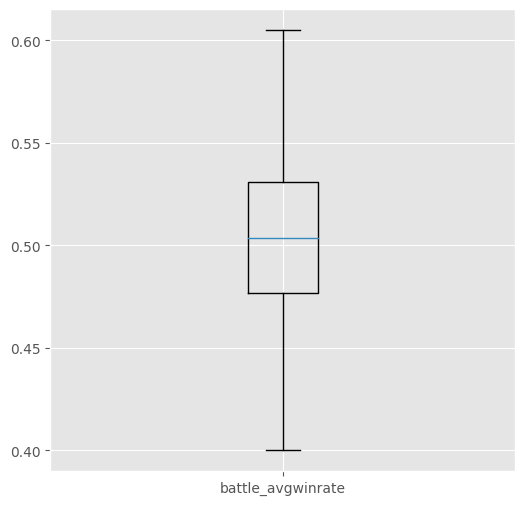

In [44]:
# subset avg winrate overall
battlelogFinal = battlelogFinal[(battlelogFinal['battle_avgwinrate_overall'] >= 0.43) & (battlelogFinal['battle_avgwinrate_overall'] <= 0.59)].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avgwinrate')

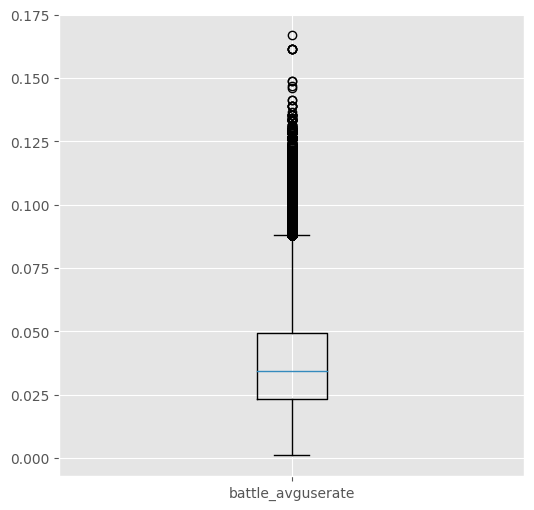

In [45]:
# crear columna avg userate
battlelogFinal['battle_avguserate'] = battlelogFinal.apply(lambda row: create_avg(row, 'userate'), axis=1)

create_boxplots(battlelogFinal, 'battle_avguserate')

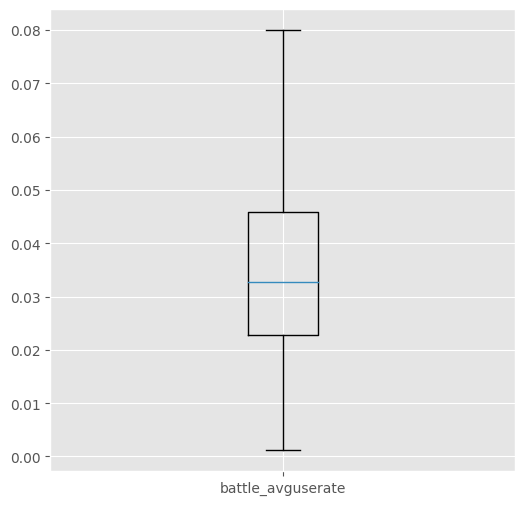

In [46]:
# subset avg userate
battlelogFinal = battlelogFinal[battlelogFinal['battle_avguserate'] <= 0.08].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avguserate')

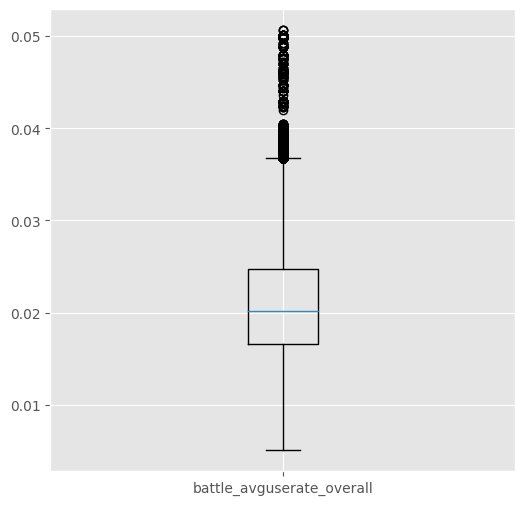

In [47]:
# crear columna avg userate overall
battlelogFinal['battle_avguserate_overall'] = battlelogFinal.apply(lambda row: create_avg(row, 'userate_overall'), axis=1)

create_boxplots(battlelogFinal, 'battle_avguserate_overall')

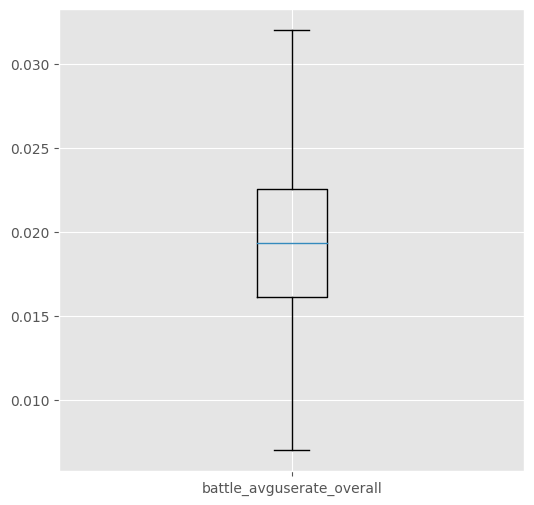

In [54]:
# subset avg userate overall
battlelogFinal = battlelogFinal[(battlelogFinal['battle_avguserate_overall'] <= 0.032) & (battlelogFinal['battle_avguserate_overall'] >= 0.007)].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle_avguserate_overall')

In [55]:
# best brawlers
def get_min_max_rest(row, column_names):
    a, b, c = row[column_names[0]], row[column_names[1]], row[column_names[2]]
    min_val = min(a, b, c)
    max_val = max(a, b, c)
    rest_val = (a + b + c) - min_val - max_val
    return min_val, max_val, rest_val

def order_rows(df, column):
	column_names = ['battle_player1_brawler_' + column, 'battle_player2_brawler_' + column, 'battle_player3_brawler_' + column]
	min_vals, max_vals, rest_vals = zip(*df.apply(lambda x: get_min_max_rest(x, column_names), axis=1))
	df['battle_' + column + '_min'] = min_vals
	df['battle_' + column + '_max'] = max_vals
	df['battle_' + column + '_med'] = rest_vals
	return df

In [56]:
battlelogFinal = order_rows(battlelogFinal, 'power')
battlelogFinal = order_rows(battlelogFinal, 'trophies')
battlelogFinal = order_rows(battlelogFinal, 'Health')
battlelogFinal = order_rows(battlelogFinal, 'Range_Num')
battlelogFinal = order_rows(battlelogFinal, 'Speed_Num')
battlelogFinal = order_rows(battlelogFinal, 'winrate')
battlelogFinal = order_rows(battlelogFinal, 'userate')
battlelogFinal = order_rows(battlelogFinal, 'winrate_overall')
battlelogFinal = order_rows(battlelogFinal, 'userate_overall')

In [57]:
battlelogFinal.shape

(583110, 115)

In [64]:
# definición final de columnas
def subset_battlelog(gamemode):

	df = battlelogFinal[[
	'winner'
	,'battle_avgtrophies'
	,'battle_trophies_min'
	,'battle_trophies_max'
	,'battle_avgpower'
	,'battle_power_min'
	,'battle_power_max'
	,'battle_avgrange'
	,'battle_Range_Num_min'
	,'battle_Range_Num_max'
	,'battle_avghealth'
	,'battle_Health_min'
	,'battle_Health_max'
	,'battle_avgspeed'
	,'battle_Speed_Num_min'
	,'battle_Speed_Num_max'
	,'battle_avgwinrate'
	,'battle_winrate_min'
	,'battle_winrate_max'
	,'battle_avgwinrate_overall'
	,'battle_winrate_overall_min'
	,'battle_winrate_overall_max'
	,'battle_avguserate'
	,'battle_userate_min'
	,'battle_userate_max'
	,'battle_avguserate_overall'
	,'battle_userate_overall_min'
	,'battle_userate_overall_max'
	]][battlelogFinal['event_mode'] == gamemode].reset_index(drop=True)

	return df

def subset_complete():
	df = battlelogFinal[[
	'winner'
	,'battle_avgtrophies'
	,'battle_trophies_min'
	,'battle_trophies_max'
	,'battle_avgpower'
	,'battle_power_min'
	,'battle_power_max'
	,'battle_avgrange'
	,'battle_Range_Num_min'
	,'battle_Range_Num_max'
	,'battle_avghealth'
	,'battle_Health_min'
	,'battle_Health_max'
	,'battle_avgspeed'
	,'battle_Speed_Num_min'
	,'battle_Speed_Num_max'
	,'battle_avgwinrate'
	,'battle_winrate_min'
	,'battle_winrate_max'
	,'battle_avgwinrate_overall'
	,'battle_winrate_overall_min'
	,'battle_winrate_overall_max'
	,'battle_avguserate'
	,'battle_userate_min'
	,'battle_userate_max'
	,'battle_avguserate_overall'
	,'battle_userate_overall_min'
	,'battle_userate_overall_max'
	]].reset_index(drop=True)

	return df

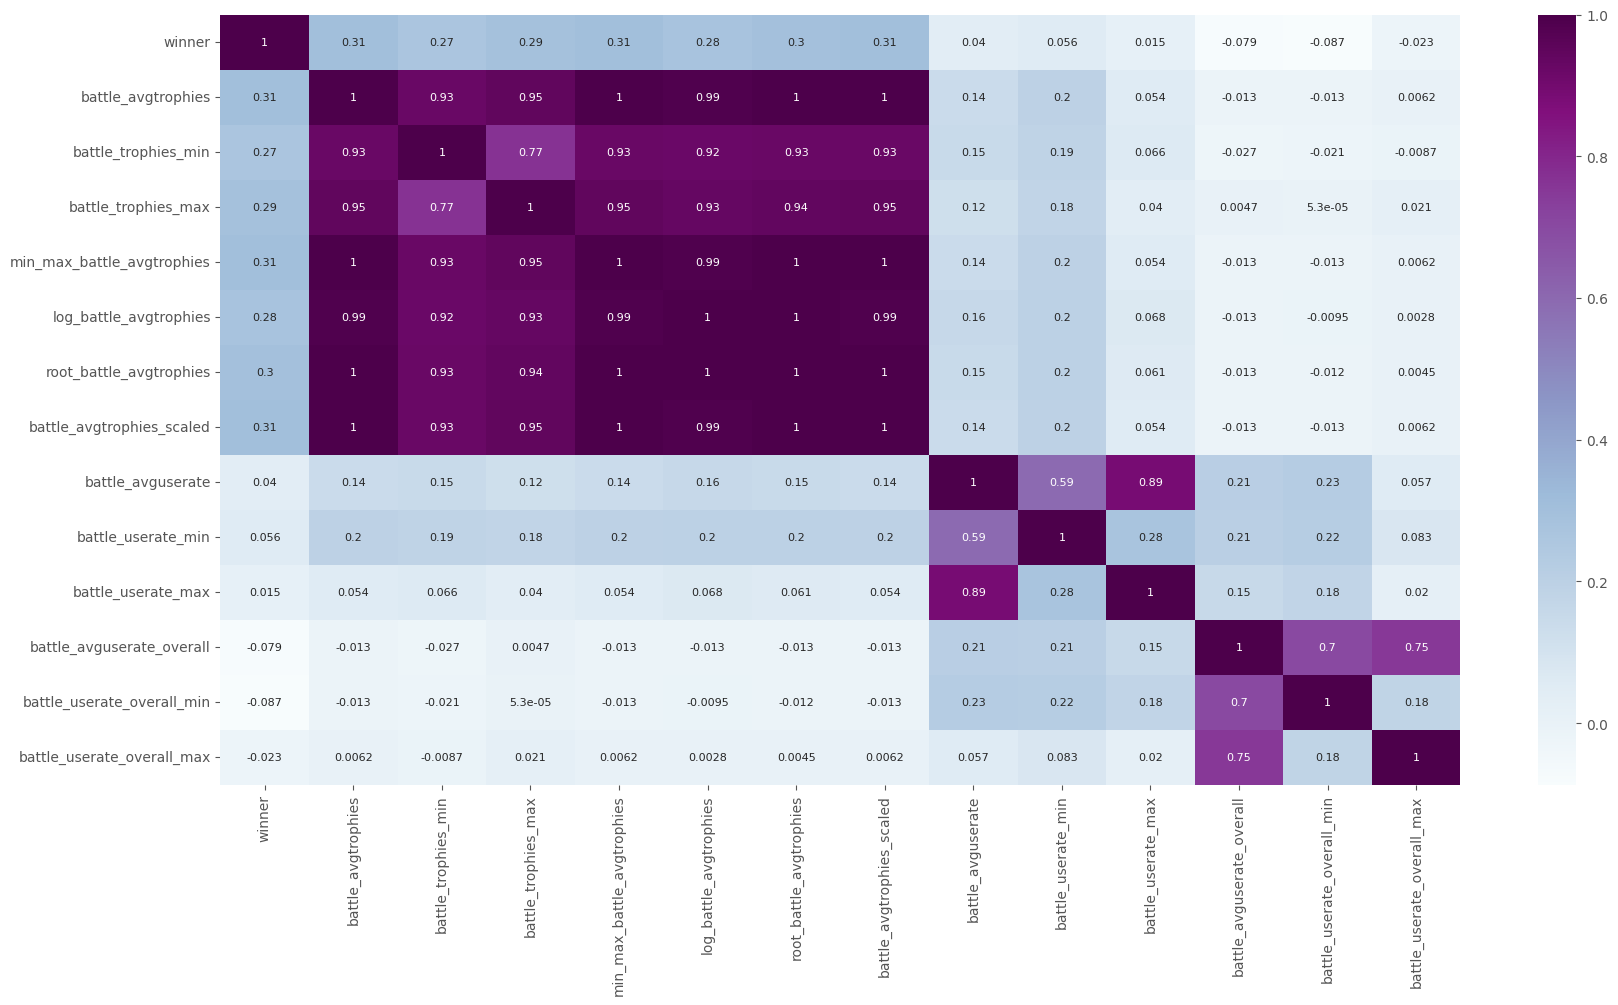

In [71]:
from sklearn.preprocessing import StandardScaler

df = subset_battlelog('hotZone')

df['winner'] = df['winner'].replace({'yes': 1, 'no': 0}).astype(int)

def min_max_scaler_column(df, column_name):
    column = df[column_name]
    scaled_column = (column - column.min()) / (column.max() - column.min())
    return scaled_column

def binning(col, n_bins):
    bins = np.linspace(col.min(), col.max(), n_bins+1)
    labels = [i for i in range(n_bins)]
    return pd.cut(col, bins=bins, labels=labels, include_lowest=True)

scaler = StandardScaler()

df['battle_avgtrophies_scaled'] = scaler.fit_transform(df['battle_avgtrophies'].values.reshape(-1, 1))

df['min_max_battle_avgtrophies'] = min_max_scaler_column(df, 'battle_avgtrophies')
df['log_battle_avgtrophies'] = np.log(df['battle_avgtrophies'])
df['root_battle_avgtrophies'] = np.sqrt(df['battle_avgtrophies'])

fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df[[
	'winner'
	,'battle_avgtrophies'
	,'battle_trophies_min'
	,'battle_trophies_max'
	,'min_max_battle_avgtrophies'
	,'log_battle_avgtrophies'
	,'root_battle_avgtrophies'
	,'battle_avgtrophies_scaled'
	# ,'battle_avgpower'
	# ,'battle_power_min'
	# ,'battle_power_max'
	# ,'battle_avgrange'
	# ,'battle_Range_Num_min'
	# ,'battle_Range_Num_max'
	# ,'battle_avghealth'
	# ,'battle_Health_min'
	# ,'battle_Health_max'
	# ,'battle_avgspeed'
	# ,'battle_Speed_Num_min'
	# ,'battle_Speed_Num_max'
	# ,'battle_avgwinrate'
	# ,'battle_winrate_min'
	# ,'battle_winrate_max'
	# ,'battle_avgwinrate_overall'
	# ,'battle_winrate_overall_min'
	# ,'battle_winrate_overall_max'
	,'battle_avguserate'
	,'battle_userate_min'
	,'battle_userate_max'
	,'battle_avguserate_overall'
	,'battle_userate_overall_min'
	,'battle_userate_overall_max'
	]].corr(), annot=True, annot_kws={"size": 8}, cmap='BuPu', ax=ax)
plt.show()

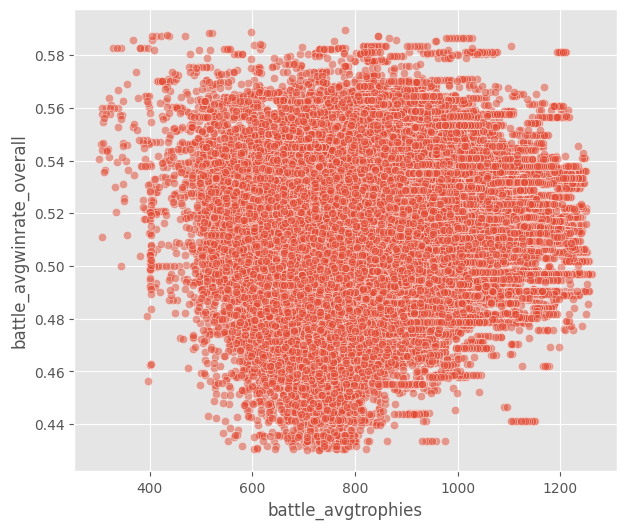

In [67]:
# scatterplot
fig, ax = plt.subplots(figsize=(7,6))
sns.scatterplot(data=df, y='battle_avgwinrate_overall', x='battle_avgtrophies', ax=ax, alpha=0.5)
plt.show()

In [277]:
df.shape

(45864, 25)

In [278]:
# cambiar working directory
print(os.getcwd())
os.chdir('machine_learning')
print(os.getcwd())

c:\Users\alniquia\OneDrive - Telefonica\Documents\Projects\BrawlStars_Model
c:\Users\alniquia\OneDrive - Telefonica\Documents\Projects\BrawlStars_Model\machine_learning


In [279]:
from pycaret.classification import *
import xgboost
import catboost
from sklearn.model_selection import train_test_split

In [291]:
# generar set de testing y training
seed=14683

train, test = train_test_split(df, test_size = 0.5, random_state=seed, stratify=df['winner'])

train.shape

(22932, 25)

In [292]:
# setup model
session_1 = setup(
	data = train,
	target = 'winner',
	fix_imbalance = True,
    feature_selection= True,
	remove_outliers=True,
	log_experiment = True,
    use_gpu=False)

,Description,Value
0,session_id,7263
1,Target,winner
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(22932, 25)"
5,Missing Values,False
6,Numeric Features,23
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [293]:
#comparación de modelos
model = compare_models(include=['rf','gbc','lightgbm','ada','catboost','xgboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.6875,0.7446,0.6703,0.7246,0.6962,0.3754,0.3768,1.9760
catboost,CatBoost Classifier,0.6857,0.7435,0.6875,0.7141,0.7004,0.3701,0.3706,8.4090
lightgbm,Light Gradient Boosting Machine,0.6844,0.7436,0.6867,0.7125,0.6992,0.3674,0.3679,0.3650
ada,Ada Boost Classifier,0.6816,0.7372,0.6415,0.7301,0.6828,0.3658,0.3690,0.6200
rf,Random Forest Classifier,0.6768,0.7296,0.6520,0.7178,0.6832,0.3550,0.3568,2.6330
xgboost,Extreme Gradient Boosting,0.6727,0.7271,0.6866,0.6969,0.6916,0.3430,0.3432,1.4980


In [33]:
#try model blender

# example:
# train a few models
# lr = create_model('lr')
# dt = create_model('dt')
# knn = create_model('knn')

# blend models
# blender = blend_models([lr, dt, knn])
# blender_tuned = tune_model(blender, optimize = 'F1')

In [34]:
# tunear el mejor modelo
model_tuned = tune_model(model, optimize = 'F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6398,0.7078,0.6411,0.6379,0.6395,0.2796,0.2796
1,0.6405,0.7036,0.6366,0.6401,0.6383,0.2810,0.2810
2,0.6394,0.7056,0.6314,0.6401,0.6357,0.2788,0.2788
3,0.6442,0.7095,0.6406,0.6437,0.6422,0.2885,0.2885
4,0.6394,0.7031,0.6382,0.6382,0.6382,0.2788,0.2788
5,0.6432,0.7048,0.6426,0.6417,0.6422,0.2864,0.2864
6,0.6453,0.7078,0.6465,0.6433,0.6449,0.2906,0.2906
7,0.6431,0.7077,0.6370,0.6432,0.6401,0.2861,0.2861
8,0.6369,0.7025,0.6302,0.6371,0.6336,0.2737,0.2737


In [35]:
# compare hyperparameters
print(model)

print(model_tuned)

In [36]:
# interpret model
# interpret_model(model_tuned)

In [37]:
plot_model(model_tuned, plot='confusion_matrix', save=True)
plot_model(model_tuned, plot='feature', save=True)
plot_model(model_tuned, plot='calibration', save=True)

'Confusion Matrix.png'

In [42]:
# finalizar modelo
model_finalized = finalize_model(model_tuned)
predictions = predict_model(model_finalized, data = test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0,0.7105,0,0,0,0,0


In [ ]:
# create_app(model_finalized)

In [43]:
save_model(model_finalized, 'models/catboost_try2')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='winner_team', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_...
                 ('feature_select',
                  Advanced_Feature_Selection_Classic(ml_usecase='classification',
                                                     n_jobs=-1,
                                                     random_state=8019,
                    

In [44]:
predictions.to_csv('datasets/predictions/predictions_lc.csv')